# Predict NYC Taxi Tips using Spark ML and Azure Open Datasets

The notebook ingests, visualizes, prepares and then trains a model based on an Open Dataset that tracks NYC Yellow Taxi trips and various attributes around them.
The goal is to predict for a given trip whether there will be a trip or not.


In [1]:
import matplotlib.pyplot as plt

from pyspark.sql.functions import unix_timestamp

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

StatementMeta(small, 7, 3, Finished, Available)

## Ingest Data¶ 

Get a sample data of nyc yellow taxi to make it faster/easier to evaluate different approaches to prep for the modelling phase later in the notebook.

In [2]:
# Import NYC yellow cab data from Azure Open Datasets
from azureml.opendatasets import NycTlcYellow

from datetime import datetime
from dateutil import parser

end_date = parser.parse('2018-05-08 00:00:00')
start_date = parser.parse('2018-05-01 00:00:00')

nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_spark_dataframe()

StatementMeta(small, 7, 4, Finished, Available)

In [3]:
#To make development easier, faster and less expensive downsample for now
sampled_taxi_df = nyc_tlc_df.sample(True, 0.001, seed=1234)

StatementMeta(small, 7, 5, Finished, Available)

## Exploratory Data Analysis

Look at the data and evaluate its suitability for use in a model, do this via some basic charts focussed on tip values and relationships.

StatementMeta(small, 7, 6, Finished, Available)

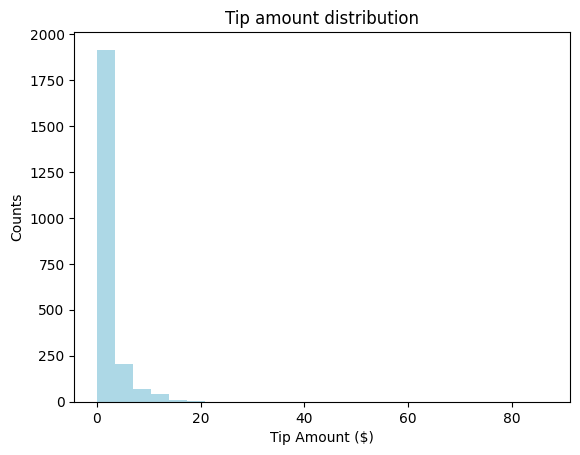

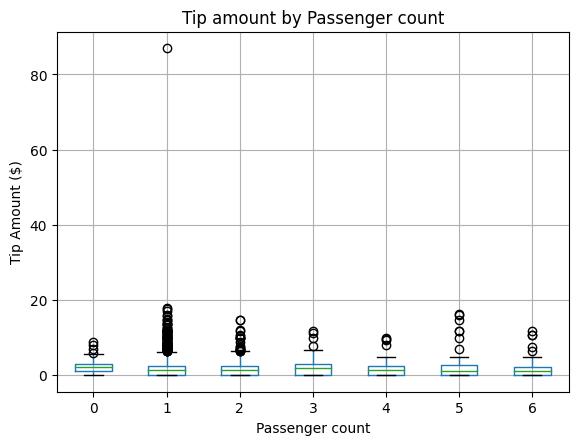

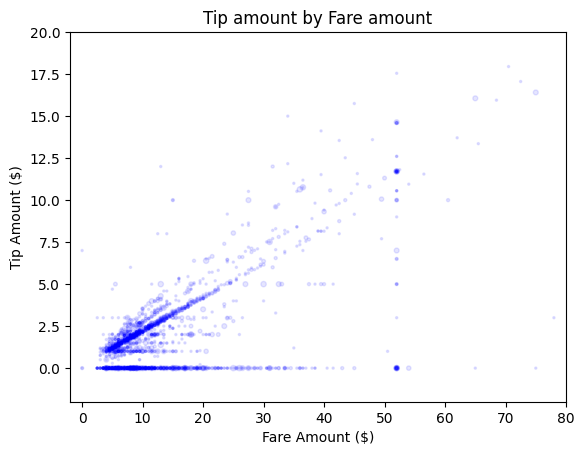

In [4]:
#The charting package needs a Pandas dataframe or numpy array do the conversion
sampled_taxi_pd_df = sampled_taxi_df.toPandas()

# Look at tips by amount count histogram
ax1 = sampled_taxi_pd_df['tipAmount'].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

# How many passengers tip'd by various amounts
ax2 = sampled_taxi_pd_df.boxplot(column=['tipAmount'], by=['passengerCount'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count') 
ax2.set_ylabel('Tip Amount ($)')
plt.suptitle('')
plt.show()

# Look at the relationship between fare and tip amounts
ax = sampled_taxi_pd_df.plot(kind='scatter', x= 'fareAmount', y = 'tipAmount', c='blue', alpha = 0.10, s=2.5*(sampled_taxi_pd_df['passengerCount']))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Tip Amount ($)')
plt.axis([-2, 80, -2, 20])
plt.suptitle('')
plt.show()

## Data Prep and Featurization

It's clear from the visualizations above that there are a bunch of outliers in the data. These will need to be filtered out in addition there are extra variables that are not going to be useful in the model we build at the end.

Finally there is a need to create some new (derived) variables that will work better with the model.


In [5]:
taxi_df = sampled_taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'rateCodeId', 'passengerCount'\
                                , 'tripDistance', 'tpepPickupDateTime', 'tpepDropoffDateTime'\
                                , date_format('tpepPickupDateTime', 'hh').alias('pickupHour')\
                                , date_format('tpepPickupDateTime', 'EEEE').alias('weekdayString')\
                                , (unix_timestamp(col('tpepDropoffDateTime')) - unix_timestamp(col('tpepPickupDateTime'))).alias('tripTimeSecs')\
                                , (when(col('tipAmount') > 0, 1).otherwise(0)).alias('tipped')
                                )\
                        .filter((sampled_taxi_df.passengerCount > 0) & (sampled_taxi_df.passengerCount < 8)\
                                & (sampled_taxi_df.tipAmount >= 0) & (sampled_taxi_df.tipAmount <= 25)\
                                & (sampled_taxi_df.fareAmount >= 1) & (sampled_taxi_df.fareAmount <= 250)\
                                & (sampled_taxi_df.tipAmount < sampled_taxi_df.fareAmount)\
                                & (sampled_taxi_df.tripDistance > 0) & (sampled_taxi_df.tripDistance <= 100)\
                                & (sampled_taxi_df.rateCodeId <= 5)
                                & (sampled_taxi_df.paymentType.isin({"1", "2"}))
                                )

StatementMeta(small, 7, 7, Finished, Available)

## Data Prep and Featurization Part 2

Having created new variables its now possible to drop the columns they were derived from so that the dataframe that goes into the model is the smallest in terms of number of variables, that is required.

Also create some more features based on new columns from the first round.


In [6]:
taxi_featurised_df = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                                , when((taxi_df.pickupHour <= 6) | (taxi_df.pickupHour >= 20),"Night")\
                                                .when((taxi_df.pickupHour >= 7) & (taxi_df.pickupHour <= 10), "AMRush")\
                                                .when((taxi_df.pickupHour >= 11) & (taxi_df.pickupHour <= 15), "Afternoon")\
                                                .when((taxi_df.pickupHour >= 16) & (taxi_df.pickupHour <= 19), "PMRush")\
                                                .otherwise(0).alias('trafficTimeBins')
                                              )\
                                       .filter((taxi_df.tripTimeSecs >= 30) & (taxi_df.tripTimeSecs <= 7200))

StatementMeta(small, 7, 8, Finished, Available)

## Encoding

Different ML algorithms support different types of input, for this example Logistic Regression is being used for Binary Classification. This means that any Categorical (string) variables must be converted to numbers.

The process is not as simple as a "map" style function as the relationship between the numbers can introduce a bias in the resulting model, the approach is to index the variable and then encode using a std approach called One Hot Encoding.

This approach requires the encoder to "learn"/fit a model over the data in the Spark instance and then transform based on what was learnt.


In [7]:
# The sample uses an algorithm that only works with numeric features convert them so they can be consumed
sI1 = StringIndexer(inputCol="trafficTimeBins", outputCol="trafficTimeBinsIndex"); 
en1 = OneHotEncoder(dropLast=False, inputCol="trafficTimeBinsIndex", outputCol="trafficTimeBinsVec");
sI2 = StringIndexer(inputCol="weekdayString", outputCol="weekdayIndex"); 
en2 = OneHotEncoder(dropLast=False, inputCol="weekdayIndex", outputCol="weekdayVec");

# Create a new dataframe that has had the encodings applied
encoded_final_df = Pipeline(stages=[sI1, en1, sI2, en2]).fit(taxi_featurised_df).transform(taxi_featurised_df)

StatementMeta(small, 7, 9, Finished, Available)

## Generation of Testing and Training Data Sets
Simple split, 70% for training and 30% for testing the model. Playing with this ratio may result in different models.


In [8]:
# Decide on the split between training and testing data from the dataframe 
trainingFraction = 0.7
testingFraction = (1-trainingFraction)
seed = 1234

# Split the dataframe into test and training dataframes
train_data_df, test_data_df = encoded_final_df.randomSplit([trainingFraction, testingFraction], seed=seed)

StatementMeta(small, 7, 10, Finished, Available)

## Train the Model

Train the Logistic Regression model and then evaluate it using Area under ROC as the metric.

In [9]:
## Create a new LR object for the model
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'tipped')

## The formula for the model
classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType+ trafficTimeBinsVec")

## Undertake training and create an LR model
lrModel = Pipeline(stages=[classFormula, logReg]).fit(train_data_df)

## Saving the model is optional but its another for of inter session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s');
fileName = "lrModel_" + datestamp;
logRegDirfilename = fileName;
lrModel.save(logRegDirfilename)

## Predict tip 1/0 (yes/no) on the test dataset, evaluation using AUROC
predictions = lrModel.transform(test_data_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

StatementMeta(small, 7, 11, Finished, Available)

Area under ROC = 0.975103734439834

## Evaluate and Visualize

Plot the actual curve to develop a better understanding of the model.


StatementMeta(small, 7, 12, Finished, Available)

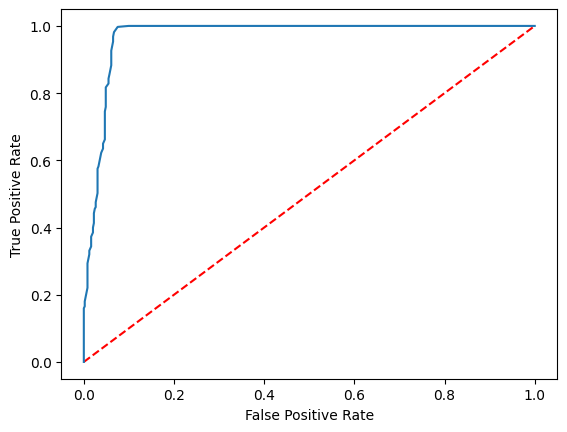

In [10]:
## Plot the ROC curve, no need for pandas as this uses the modelSummary object
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()